In [1]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import squarify
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option("display.width", 1000)
pd.set_option('display.float_format', lambda x: '%.8f' % x)
import os


In [2]:
df_ = pd.read_csv(r"/Users/abdullahcetin/Documents/python /git_folder/Data_set/data.csv", encoding= 'unicode_escape')
df = df_.copy()

def check_df(dataframe):
    print("##################### First 10 Observations #####################")
    print(dataframe.head(10))
    print("##################### Column names #####################")
    print(df.info())
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Types #####################")
    print(dataframe.dtypes)
check_df(df)

##################### First 10 Observations #####################
  InvoiceNo StockCode                          Description  Quantity     InvoiceDate  UnitPrice     CustomerID         Country
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6  12/1/2010 8:26 2.55000000 17850.00000000  United Kingdom
1    536365     71053                  WHITE METAL LANTERN         6  12/1/2010 8:26 3.39000000 17850.00000000  United Kingdom
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8  12/1/2010 8:26 2.75000000 17850.00000000  United Kingdom
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6  12/1/2010 8:26 3.39000000 17850.00000000  United Kingdom
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6  12/1/2010 8:26 3.39000000 17850.00000000  United Kingdom
5    536365     22752         SET 7 BABUSHKA NESTING BOXES         2  12/1/2010 8:26 7.65000000 17850.00000000  United Kingdom
6    536365     21730    GLASS STAR FROSTED T

In [3]:
# Data cleaning
df.dropna(inplace=True)
df = df[~df["InvoiceNo"].str.contains("C", na=False)] 
df = df[df["Quantity"] > 0]
df = df[df["UnitPrice"] > 0]
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,397884.00000000,12.98823778,179.33177496,1.00000000,2.00000000,6.00000000,12.00000000,80995.00000000
UnitPrice,397884.00000000,3.11648776,22.09787663,0.00100000,1.25000000,1.95000000,3.75000000,8142.75000000
CustomerID,397884.00000000,15294.42345256,1713.14156044,12346.00000000,13969.00000000,15159.00000000,16795.00000000,18287.00000000


In [4]:
print(df.shape )
df["InvoiceNo"].nunique()

(397884, 8)


18532

In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55000000,17850.00000000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39000000,17850.00000000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75000000,17850.00000000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39000000,17850.00000000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39000000,17850.00000000,United Kingdom


In [6]:
# correction of outliers.

def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [7]:
replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "UnitPrice")
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,397884.00000000,11.83079742,25.52307825,1.00000000,2.00000000,6.00000000,12.00000000,298.50000000
UnitPrice,397884.00000000,2.89345363,3.22709045,0.00100000,1.25000000,1.95000000,3.75000000,37.06000000
CustomerID,397884.00000000,15294.42345256,1713.14156044,12346.00000000,13969.00000000,15159.00000000,16795.00000000,18287.00000000


In [8]:
#calculation of total price.
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.00000000,12/1/2010 8:26,2.55000000,17850.00000000,United Kingdom,15.30000000
1,536365,71053,WHITE METAL LANTERN,6.00000000,12/1/2010 8:26,3.39000000,17850.00000000,United Kingdom,20.34000000
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.00000000,12/1/2010 8:26,2.75000000,17850.00000000,United Kingdom,22.00000000
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.00000000,12/1/2010 8:26,3.39000000,17850.00000000,United Kingdom,20.34000000
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.00000000,12/1/2010 8:26,3.39000000,17850.00000000,United Kingdom,20.34000000


In [9]:

df.groupby("InvoiceNo").agg({"TotalPrice":"sum"}).head()

,TotalPrice
InvoiceNo,
536365,139.12000000
536366,22.20000000
536367,278.73000000
536368,70.05000000
536369,17.85000000


In [10]:
df["InvoiceDate"] = df["InvoiceDate"].apply(pd.to_datetime)

In [11]:
df.InvoiceDate.max() #'9/9/2011 9:52'


Timestamp('2011-12-09 12:50:00')

In [12]:
today_date = dt.datetime(2011, 12, 11)

In [13]:
# calculation of rfm metrics

cltv_df = df.groupby('CustomerID').agg(
    {'InvoiceDate': [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days,
                     lambda InvoiceDate: (today_date - InvoiceDate.min()).days],
     'InvoiceNo': lambda InvoiceNo: InvoiceNo.nunique(),
     'TotalPrice': lambda TotalPrice: TotalPrice.sum()})
cltv_df.columns = cltv_df.columns.droplevel(0)
cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']
cltv_df = cltv_df[cltv_df["monetary"] > 0]
cltv_df.head()

,recency,T,frequency,monetary
CustomerID,,,,
12346.00000000,0,326,1,310.44000000
12347.00000000,365,368,7,4310.00000000
12348.00000000,282,359,4,1770.78000000
12349.00000000,0,19,1,1491.72000000
12350.00000000,0,311,1,331.46000000


In [14]:
# Calculation fo RFM score.
cltv_df['Recency_Score'] = pd.qcut(cltv_df['recency'].rank(method="first") , 5,labels=[5, 4, 3, 2, 1])
cltv_df['Frequency_Score'] = pd.qcut(cltv_df['recency'].rank(method="first") , 5,labels=[1, 2, 3, 4, 5])
cltv_df['Monetary_Score'] = pd.qcut(cltv_df['recency'].rank(method="first") , 5,labels=[1, 2, 3, 4, 5])
cltv_df['RFM_Score'] = (cltv_df['Recency_Score'].astype(str) +cltv_df['Frequency_Score'].astype(str))
cltv_df.head()

,recency,T,frequency,monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score
CustomerID,,,,,,,,
12346.00000000,0,326,1,310.44000000,5,1,1,51
12347.00000000,365,368,7,4310.00000000,1,5,5,15
12348.00000000,282,359,4,1770.78000000,1,5,5,15
12349.00000000,0,19,1,1491.72000000,5,1,1,51
12350.00000000,0,311,1,331.46000000,5,1,1,51


In [15]:


seg_map={
    r'[1-2][1-2]':'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33' : ' need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalsts',
    r'5[4-5]':'champions'
}
cltv_df['Segment_RFM'] = cltv_df['RFM_Score'].replace(seg_map, regex=True)
cltv_df.head()

,recency,T,frequency,monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score,Segment_RFM
CustomerID,,,,,,,,,
12346.00000000,0,326,1,310.44000000,5,1,1,51,new_customers
12347.00000000,365,368,7,4310.00000000,1,5,5,15,cant_loose
12348.00000000,282,359,4,1770.78000000,1,5,5,15,cant_loose
12349.00000000,0,19,1,1491.72000000,5,1,1,51,new_customers
12350.00000000,0,311,1,331.46000000,5,1,1,51,new_customers


In [16]:
cltv_df[["Segment_RFM","recency", "frequency", "monetary"]].groupby("Segment_RFM").agg(['mean', 'count'])

recency         frequency            monetary      
                           mean count        mean count          mean count
Segment_RFM                                                                
 need_attention     94.16705069   868  3.12096774   868 1134.48850346   868
at_Risk            222.60784314   867  4.77393310   867 1729.77259054   867
cant_loose         332.07027650   868 11.06912442   868 5774.06360023   868
new_customers        0.00000000   868  1.02995392   868  394.24408986   868
potential_loyalsts   3.35755479   867  1.36332180   867  426.45576355   867

In [17]:
# calculation of cltv

cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"] # To calculate average monetary

cltv_df = cltv_df[(cltv_df['frequency'] > 1)] # To get rid of values that are equal to 0
# cltv_df = cltv_df[(cltv_df['recency'] > 1)]
cltv_df["recency"] = cltv_df["recency"] / 7  # converting days to weeks

cltv_df["T"] = cltv_df["T"] / 7 # converting days to weeks

cltv_df.head()
check_df(cltv_df)

##################### First 10 Observations #####################
                   recency           T  frequency      monetary Recency_Score Frequency_Score Monetary_Score RFM_Score      Segment_RFM
CustomerID                                                                                                                             
12347.00000000 52.14285714 52.57142857          7  615.71428571             1               5              5        15       cant_loose
12348.00000000 40.28571429 51.28571429          4  442.69500000             1               5              5        15       cant_loose
12352.00000000 37.14285714 42.42857143          8  219.54250000             2               4              4        24          at_Risk
12356.00000000 43.14285714 46.57142857          3  937.14333333             1               5              5        15       cant_loose
12358.00000000 21.28571429 21.57142857          2  575.21000000             3               3              3        33

In [18]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,2.18231589,0.07561869,2.03410325,2.33052852
alpha,11.40788437,0.46062226,10.50506474,12.31070400
a,0.11857810,0.01268537,0.09371478,0.14344143
b,2.49082634,0.22930654,2.04138551,2.94026716


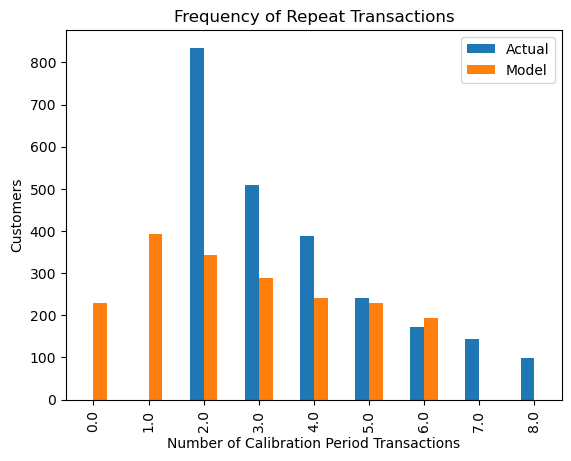

In [19]:
plot_period_transactions(bgf)
plt.show(block=True)

In [20]:
cltv_df["expected_purc_a_month"] = bgf.conditional_expected_number_of_purchases_up_to_time(4, cltv_df['frequency'], cltv_df['recency'], cltv_df['T'])

cltv_df["expected_purc_3_month"] = bgf.predict(12, cltv_df['frequency'], cltv_df['recency'], cltv_df['T'])

cltv_df.head()

,recency,T,frequency,monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score,Segment_RFM,expected_purc_a_month,expected_purc_3_month
CustomerID,,,,,,,,,,,
12347.00000000,52.14285714,52.57142857,7,615.71428571,1,5,5,15,cant_loose,0.56350839,1.67837267
12348.00000000,40.28571429,51.28571429,4,442.69500000,1,5,5,15,cant_loose,0.36675891,1.09202740
12352.00000000,37.14285714,42.42857143,8,219.54250000,2,4,4,24,at_Risk,0.72710369,2.16305381
12356.00000000,43.14285714,46.57142857,3,937.14333333,1,5,5,15,cant_loose,0.34352024,1.02215460
12358.00000000,21.28571429,21.57142857,2,575.21000000,3,3,3,33,need_attention,0.48622691,1.43878750


In [21]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

ggf.fit(cltv_df['frequency'], cltv_df['monetary'])

<lifetimes.GammaGammaFitter: fitted with 2845 subjects, p: 3.79, q: 0.34, v: 3.73>

In [22]:
cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                             cltv_df['monetary']) #per puchase
cltv_df.head()

,recency,T,frequency,monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score,Segment_RFM,expected_purc_a_month,expected_purc_3_month,expected_average_profit
CustomerID,,,,,,,,,,,,
12347.00000000,52.14285714,52.57142857,7,615.71428571,1,5,5,15,cant_loose,0.56350839,1.67837267,631.91226812
12348.00000000,40.28571429,51.28571429,4,442.69500000,1,5,5,15,cant_loose,0.36675891,1.09202740,463.74592351
12352.00000000,37.14285714,42.42857143,8,219.54250000,2,4,4,24,at_Risk,0.72710369,2.16305381,224.88675871
12356.00000000,43.14285714,46.57142857,3,937.14333333,1,5,5,15,cant_loose,0.34352024,1.02215460,995.99880439
12358.00000000,21.28571429,21.57142857,2,575.21000000,3,3,3,33,need_attention,0.48622691,1.43878750,631.90205199


In [23]:
# calculation of cltv 
cltv_df["cltv"] = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=3,
                                   freq="W",  # Frequency period ("Weeks")
                                   discount_rate=0.01)
cltv_df.head()

,recency,T,frequency,monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score,Segment_RFM,expected_purc_a_month,expected_purc_3_month,expected_average_profit,cltv
CustomerID,,,,,,,,,,,,,
12347.00000000,52.14285714,52.57142857,7,615.71428571,1,5,5,15,cant_loose,0.56350839,1.67837267,631.91226812,1128.44760245
12348.00000000,40.28571429,51.28571429,4,442.69500000,1,5,5,15,cant_loose,0.36675891,1.09202740,463.74592351,538.80890192
12352.00000000,37.14285714,42.42857143,8,219.54250000,2,4,4,24,at_Risk,0.72710369,2.16305381,224.88675871,517.49999641
12356.00000000,43.14285714,46.57142857,3,937.14333333,1,5,5,15,cant_loose,0.34352024,1.02215460,995.99880439,1083.09012769
12358.00000000,21.28571429,21.57142857,2,575.21000000,3,3,3,33,need_attention,0.48622691,1.43878750,631.90205199,966.67252349


In [24]:
cltv_df["Segment_Cltv"] = pd.qcut(cltv_df["cltv"], 4, labels=["D", "C", "B", "A"])
cltv_df.sort_values("cltv", ascending = False).head(20)

,recency,T,frequency,monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score,Segment_RFM,expected_purc_a_month,expected_purc_3_month,expected_average_profit,cltv,Segment_Cltv
CustomerID,,,,,,,,,,,,,,
14646.00000000,50.42857143,50.71428571,73,3646.07568493,1,5,5,15,cant_loose,4.81191515,14.33398549,3654.81479633,55741.08421824,A
18102.00000000,52.28571429,52.57142857,60,3859.73908333,1,5,5,15,cant_loose,3.86359860,11.51115732,3870.99690950,47412.57985199,A
14096.00000000,13.85714286,14.57142857,17,3163.58823529,3,3,3,33,need_attention,2.89554070,8.55264875,3196.43599431,29061.66081834,A
12415.00000000,44.71428571,48.28571429,21,5724.30261905,1,5,5,15,cant_loose,1.51389524,4.50797458,5772.17807953,27685.09957001,A
14911.00000000,53.14285714,53.42857143,201,691.71009950,1,5,5,15,cant_loose,12.47219759,37.16410950,692.32636634,27377.41147662,A
17450.00000000,51.28571429,52.57142857,46,2863.27489130,1,5,5,15,cant_loose,2.98153026,8.88298594,2874.19866366,27166.06414719,A
14156.00000000,51.57142857,53.14285714,55,2104.02672727,1,5,5,15,cant_loose,3.50047757,10.42981493,2110.75421374,23424.40303848,A
17511.00000000,52.85714286,53.42857143,31,2933.94306452,1,5,5,15,cant_loose,2.02975910,6.04764949,2950.58010081,18986.61213333,A
16684.00000000,50.42857143,51.28571429,28,2209.96910714,1,5,5,15,cant_loose,1.90683951,5.68012403,2223.88494708,13440.41292531,A


In [25]:
cltv_df.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,2845.00000000,28.41506402,16.26670871,0.00000000,14.00000000,29.57142857,42.71428571,53.28571429
T,2845.00000000,36.96916897,14.71298879,0.42857143,27.42857143,40.42857143,51.28571429,53.42857143
frequency,2845.00000000,5.98910369,9.04424704,2.00000000,2.00000000,4.00000000,6.00000000,209.00000000
monetary,2845.00000000,372.17198109,349.30188467,3.45000000,191.07333333,300.48730769,436.87000000,5724.30261905
expected_purc_a_month,2845.00000000,0.62456713,0.59224199,0.00000000,0.33612553,0.50950199,0.75699486,12.96333999
expected_purc_3_month,2845.00000000,1.85276360,1.76071315,0.00000000,0.99918670,1.51150308,2.24499763,38.62761980
expected_average_profit,2845.00000000,392.23489125,363.73317196,5.81948218,203.92669065,316.53934717,459.63517449,5772.17807953
cltv,2845.00000000,858.42245011,2058.20279110,0.00000000,265.11375774,508.30801185,922.55002418,55741.08421824


In [26]:

cltv_df.groupby("Segment_Cltv")[["expected_purc_a_month", "expected_purc_3_month","expected_average_profit","cltv" ]].agg({"count", "mean", "sum"}).sort_values("Segment_Cltv",ascending = False)

expected_purc_a_month                         expected_purc_3_month                          expected_average_profit                               cltv                               
                             count          sum       mean                 count           sum       mean                   count             sum         mean count              sum          mean
Segment_Cltv                                                                                                                                                                                       
A                              711 774.32977495 1.08907141                   711 2297.14479014 3.23086468                     711 487674.68774160 685.89970146   711 1580097.84815193 2222.35984269
B                              711 459.69262274 0.64654377                   711 1362.65946694 1.91653933                     711 280054.21122558 393.88777950   711  489343.56810486  688.24693123
C                              711 341.39362939 0.48015982                   711 1013.21764285 1.42505998                     711 206179.72165714 289.98554382   711  270742.97757197  380.79181093
D                              712 201.47744614 0.28297394                   712  598.09053390 0.84001479                     712 141999.64498822 199.43770364   712  102027.47673530  143.29701789

In [27]:
# cltv_df[(cltv_df["Segment_Cltv"] == "A") & (cltv_df["Segment_RFM"] == "cant_loose")].head()

cltv_df[cltv_df["Segment_Cltv"] == "A"][["RFM_Score","Segment_RFM","cltv"]].sort_values("cltv", ascending=False).head()

,RFM_Score,Segment_RFM,cltv
CustomerID,,,
14646.00000000,15,cant_loose,55741.08421824
18102.00000000,15,cant_loose,47412.57985199
14096.00000000,33,need_attention,29061.66081834
12415.00000000,15,cant_loose,27685.09957001
14911.00000000,15,cant_loose,27377.41147662
